In [30]:
import pennylane as qml
from pennylane import numpy as np

import matplotlib.pyplot as plt
# from problems.ising_problem2 import IsingProblem2
from problems.ising_problem import IsingProblem
from problems.toy_benchmark_problem import ToyProblem
from qiskit.providers.fake_provider import *
from bin.cost_function import cost_loc, calc_err, cost_global, local_hadamard_test, hadamard_overlap_test
from bin.hyperparameters import *
from bin.error_mitigation import mitigate_node

import time

In [31]:
# # Import the library that you need in order to use your IBM account
# from qiskit_ibm_provider import IBMProvider
# from secrets import *


# try:
#     IBMProvider()
# except:
#     IBMProvider.save_account(token=IBM_token, overwrite=True)

In [32]:
# provider = IBMProvider()
# provider.backends()

In [33]:
def configured_backend():
    # backend = provider.get_backend("ibm_osaka") # uncomment this line to use a real IBM device
    backend = FakeManila()
    # backend.options.update_options(...)
    return backend

In [34]:
# define the problem we want to perform our experiment on
n_qubits = 3
error = 1.6 * 10**-3
cond_num = 2

# problem = IsingProblem(n_qubits=n_qubits, J=0.1, cond_num=cond_num)
problem = ToyProblem(n_qubits=n_qubits)

['III', 'XXX']


In [35]:
# initialize weights
w = q_delta * np.random.randn(problem.param_shape, requires_grad=True)
w1 = w.copy()
init_weights = list(w.copy().numpy())
# w = q_delta * np.random.randn(batch_size, problem.param_shape, requires_grad=True)

In [36]:
# create our devices to run our circuits on
# dev_mu = qml.device("default.qubit", wires=n_qubits+1)
noise_strength = 0.01
# dev_mu = qml.device("default.mixed", wires=n_qubits+1)
# dev_mu = qml.transforms.insert(
#     dev_mu,
#     qml.BitFlip,
#     noise_strength
# )
dev_gamma = qml.device("default.qubit", wires=n_qubits*2 + 1)
dev_mu = qml.device("qiskit.remote", wires=n_qubits+1, backend=configured_backend()) # device for real IBM devices noisy simulators

In [37]:
# in order to make the error mitigation work, we have to pull out the QNode definition outside of the cost function so I'm doing it here
local_hadamard_test = qml.QNode(local_hadamard_test, dev_mu, interface="autograd")
# local_hadamard_test = mitigate_node(local_hadamard_test)

In [38]:
# # use non-ML optimization methods
from scipy.optimize import minimize

cost_history2 = []

def cost_fun(w):
    cost = cost_loc(problem, w, local_hadamard_test)
    cost_history2.append(cost)
    # w1s_nonML.append(w[0])
    # w2s_nonML.append(w[1])

    return cost

if OPTIMIZER == "COBYLA":
    start = time.time()
    res = minimize(cost_fun,
                    w1,
                    method='COBYLA',
                    tol=(error**2)/(n_qubits * cond_num**2)
                    )
    TTS = time.time() - start

    w1 = res.x
    calc_err(n_qubits, cost_history2[-1], cond_num)

Traceback (most recent call last):
  File "/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 258, in calcfc
capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Fatal Python error: F2PySwapThreadLocalCallbackPtr: F2PySwapThreadLocalCallbackPtr: PyLong_AsVoidPtr failed
Python runtime state: initialized
    f = fun(np.copy(x), *args)
        ^^^^^^^^^^^^^^^^^^^^^^
  File "/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_94843/190235117.py", line 7, in cost_fun
  File "/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/bin/cost_function.py", line 156, in cost_loc
    mu_sum = mu_sum + c[l] * np.conj(c[lp]) * mu(weights, local_hadamard_test, problem, l, lp, j)
                                              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/bin/cost_function.py", line 52, in mu


: 

In [ ]:
from IPython.display import clear_output

opt = qml.GradientDescentOptimizer(eta)
# opt = qml.AdagradOptimizer(eta)
# opt = qml.AdamOptimizer(eta) # TODO: tune decay terms

cost_history = []

err = float("inf")
it = 1

In [ ]:
# # %%
# # training loop

# best_err = 1000
# best_w = w
# prev_err = 0

# ERR_1000 = None
# TTS_1000 = None

# start = time.time()
# while err > error:
# # for it in range(steps):
#     # w, cost = opt.step_and_cost(cost_agg, w)
#     w, cost = opt.step_and_cost(lambda w: cost_loc(problem, w, local_hadamard_test), w)
#     # w, cost = opt.step_and_cost(lambda w: cost_global(problem, w, local_hadamard_test, hadamard_overlap_test), w)

#     err = calc_err(n_qubits, cost, cond_num)
#     if err < best_err:
#         best_err = err
#         best_w = w
    
#     clear_output(wait=True)

#     # print(np.array_equal(best_w, w))

#     print("Step {:3d}       Cost_L = {:9.7f} \t error = {:9.7f}".format(it, cost, err), flush=True)
#     cost_history.append(cost)

#     if abs(prev_err - err) < 10**-9:
#         break

#     prev_err = err

#     if it == 1000:
#         ERR_1000 = err
#         TTS_1000 = time.time() - start

#     it += 1

# TTS = time.time() - start
# print(f"Training time: {TTS}s")

In [ ]:
# best_err

### Optimization studies:
- each epoch is taking ~ 20s
- Each $\mu$ calculation takes ~0.05s but occasionally spikes to ~0.3s
- Each $\mu_{sum}$ has to loop over each combination of A_l for each qubit -> $c^2n$ operations -> ~15s
- Each $|\psi|$ also has to loop over each combination, but we're unable to recycle computation because these don't apply $CZ$ like the above -> ~4s
- The ising problem has 8 C's
    - Note that `len(c) = n_qubits * 2` by definition of H_ising
- 8 * 8 * 4 * 2 = ~512 mu accumulations

--> $8n^3 + 4n^2$ iterations

It should be possible to multithread the calculation, but not sure if that's feasible when testing on an actual QC


* n_qubits = 5: 1100 mu accumulations
* n_qubits = 6: 1872 mu accumulations
* n_qubits = 7: 2940 mu accumulations

/var/folders/46/x_y_zr5s2rj1v37fwfjmjh9r0000gn/T/ipykernel_94843/2618526565.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


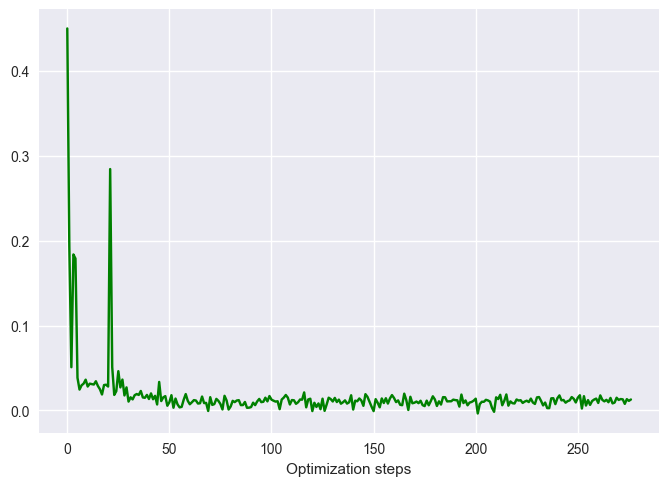

In [ ]:
plt.style.use("seaborn")
# plt.plot(np.log(cost_history), "g")
# plt.plot(cost_history, "g")
plt.plot(cost_history2, "g")
# plt.ylabel("Cost function")
plt.xlabel("Optimization steps")
plt.show()

Qualitatively, it's converging slower than the toy problem, suggesting more iterations are needed

In [ ]:
from bin.inference import get_cprobs, get_qprobs
c_probs = get_cprobs(problem)

dev_x = qml.device("qiskit.remote", wires=n_qubits, backend=configured_backend(), shots=n_shots)
dev_x2 = qml.device("default.mixed", wires=n_qubits, shots=n_shots)
# dev_x = qml.transforms.insert(
#     dev_x,
#     qml.BitFlip,
#     noise_strength
# )
# dev_x = qml.device("default.qubit", wires=n_qubits, shots=n_shots)

def prepare_and_sample(problem, weights):

    # Variational circuit generating a guess for the solution vector |x>
    problem.variational_block(weights)

    # We assume that the system is measured in the computational basis.
    # then sampling the device will give us a value of 0 or 1 for each qubit (n_qubits)
    # this will be repeated for the total number of shots provided (n_shots)
    return qml.sample()

def get_qprobs(problem, w, device):
    sampler = qml.QNode(prepare_and_sample, device)

    # sampler = mitigate_node(sampler)

    raw_samples = sampler(problem, w)
    # raw_samples = np.concatenate(raw_samples, axis=0)# FOR BATCHING

    # convert the raw samples (bit strings) into integers and count them
    samples = []
    for sam in raw_samples:
        samples.append(int("".join(str(int(bs)) for bs in sam), base=2))

    q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / len(raw_samples)
    # q_probs = np.bincount(samples, minlength=2**problem.n_qubits) / n_shots

    return q_probs


# q_probs = get_qprobs(problem, best_w, dev_x)
q_probs2 = get_qprobs(problem, w1, dev_x)
q_probs2_ideal = get_qprobs(problem, w1, dev_x2)
# q_probs3 = get_qprobs(problem, [1.5705046150451736, 1.5705041724710558, -0.0009846128569860652, 0.000984610085330146, 0.00029202653119376993, 0.0002918396812539236, 0.0012198785697687766, -0.0010337890860256797, 0.0009437314407577103, 0.001185472295695717, 0.0020100669403005198, 0.0005855538999739717, 0.000525121845110425, -0.0009814305643716197, 0.00029608381115290634, -2.7253248349064283e-05, -0.0014873097674744367, 0.0003028086025783615, -0.0013560394256734397, -7.271131181252964e-05], dev_x)

/Users/bigsad/Downloads/Algorithm-Research/Student-Hub/Indy-Ng/.venv/lib/python3.11/site-packages/matplotlib/transforms.py:762: ComplexWarning: Casting complex values to real discards the imaginary part
  points = np.asarray(points, float)


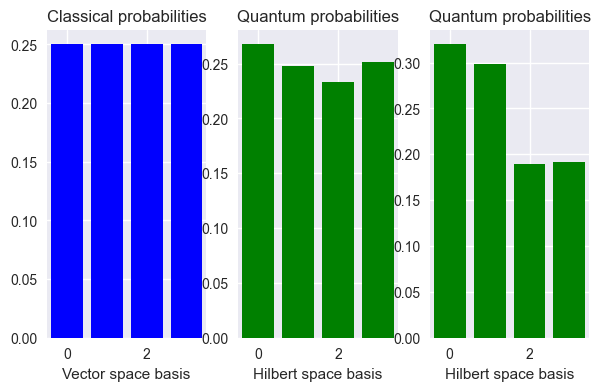

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(7, 4))

ax1.bar(np.arange(0, 2 ** n_qubits), c_probs, color="blue")
ax1.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax1.set_xlabel("Vector space basis")
ax1.set_title("Classical probabilities")

# ax2.bar(np.arange(0, 2 ** n_qubits), q_probs, color="green")
# ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
# ax2.set_xlabel("Hilbert space basis")
# ax2.set_title("Quantum probabilities")

ax2.bar(np.arange(0, 2 ** n_qubits), q_probs2_ideal, color="green")
ax2.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax2.set_xlabel("Hilbert space basis")
ax2.set_title("Quantum probabilities")

ax3.bar(np.arange(0, 2 ** n_qubits), q_probs2, color="green")
ax3.set_xlim(-0.5, 2 ** n_qubits - 0.5)
ax3.set_xlabel("Hilbert space basis")
ax3.set_title("Quantum probabilities")

# ax3.bar(np.arange(0, 2 ** n_qubits), q_probs3, color="green")
# ax3.set_xlim(-0.5, 2 ** n_qubits - 0.5)
# ax3.set_xlabel("Hilbert space basis")
# ax3.set_title("Quantum probabilities")

plt.show()

In [ ]:
# print(f"noisy sampling: {np.mean(abs(c_probs - q_probs2))}")
# print(f"ideal sampling: {np.mean(abs(c_probs - q_probs2_ideal))}")

noisy sampling: 0.059138500000000004
ideal sampling: 0.009291999999999995


In [ ]:
result = {
    "problem": str(problem),
    "n_qubits": n_qubits,
    # "ansatz": f"{problem.n_layers}-layer HEA",
    "cost": "local",
    "optimizer": OPTIMIZER,
    "cond_num": cond_num,
    "error_threshold": error,
    "noise_model": NOISE_MODEL,
    "TTS": TTS,
    "STS": len(cost_history2) if OPTIMIZER == "COBYLA" else len(cost_history),
    "final_error": calc_err(n_qubits, cost_history2[-1], cond_num).item(),
    "cost_history": list(cost_history) if OPTIMIZER != "COBYLA" else [tensor.item() for tensor in cost_history2],
    "model_weights": list(w1) if OPTIMIZER == "COBYLA" else list(w.numpy()),
    "init_weights": init_weights
}

In [ ]:
# serialize to JSON?
import json

with open(f'data/Toy_{OPTIMIZER}_{NOISE_MODEL}.json', 'a') as fp:
    fp.write(",")
    json.dump(result, fp)